In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X = pd.read_csv('C:/Users/yasha/missing_values_train.csv', index_col='Id') 
X_test = pd.read_csv('C:/Users/yasha/missing_values_test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice
X.drop(['SalePrice'], axis=1, inplace=True)

# To keep things simple, we'll drop columns with missing values
cols_with_missing = [col for col in X.columns if X[col].isnull().any()] 
X.drop(cols_with_missing, axis=1, inplace=True)
X_test.drop(cols_with_missing, axis=1, inplace=True)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [2]:
X_train.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
619,20,RL,11694,Pave,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,...,108,0,0,260,0,0,7,2007,New,Partial
871,20,RL,6600,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0,0,0,0,0,0,8,2009,WD,Normal
93,30,RL,13360,Pave,IR1,HLS,AllPub,Inside,Gtl,Crawfor,...,0,44,0,0,0,0,8,2009,WD,Normal
818,20,RL,13265,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,...,59,0,0,0,0,0,7,2008,WD,Normal
303,20,RL,13704,Pave,IR1,Lvl,AllPub,Corner,Gtl,CollgCr,...,81,0,0,0,0,0,1,2006,WD,Normal


In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

# Step 1: Drop columns with categorical data

In [4]:
# Fill in the lines below: drop columns in training and validation data
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_valid.select_dtypes(exclude=['object'])

In [5]:
print("MAE from Approach 1 (Drop categorical variables):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop categorical variables):
17837.82570776256


# Step 2: Label encoding

In [6]:
print("Unique values in 'Condition2' column in training data:", X_train['Condition2'].unique())
print("\nUnique values in 'Condition2' column in validation data:", X_valid['Condition2'].unique())

Unique values in 'Condition2' column in training data: ['Norm' 'PosA' 'Feedr' 'PosN' 'Artery' 'RRAe']

Unique values in 'Condition2' column in validation data: ['Norm' 'RRAn' 'RRNn' 'Artery' 'Feedr' 'PosN']


Fitting a label encoder to a column in the training data creates a corresponding integer-valued label for each unique value that appears in the training data. In the case that the validation data contains values that don't also appear in the training data, the encoder will throw an error, because these values won't have an integer assigned to them. Notice that the 'Condition2' column in the validation data contains the values 'RRAn' and 'RRNn', but these don't appear in the training data thus, if we try to use a label encoder with scikit-learn, the code will throw an error.

To save the problematic columns to a Python list `bad_label_cols`.  Likewise, columns that can be safely label encoded are stored in `good_label_cols`.

In [7]:
# All categorical columns
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that can be safely label encoded
good_label_cols = [col for col in object_cols if set(X_train[col]) == set(X_valid[col])]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print('Categorical columns that will be label encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

Categorical columns that will be label encoded: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'BldgType', 'HouseStyle', 'ExterQual', 'CentralAir', 'KitchenQual', 'PavedDrive', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['Condition2', 'Exterior1st', 'LandSlope', 'SaleType', 'Foundation', 'RoofMatl', 'Heating', 'Functional', 'ExterCond', 'Condition1', 'Exterior2nd', 'Neighborhood', 'HeatingQC', 'Utilities', 'RoofStyle']


Set the preprocessed DataFrames to `label_X_train` and `label_X_valid`. 
label encode the categorical columns in `good_label_cols`.  

In [8]:
from sklearn.preprocessing import LabelEncoder

# Drop categorical columns that will not be encoded
label_X_train = X_train.drop(bad_label_cols, axis=1)
label_X_valid = X_valid.drop(bad_label_cols, axis=1)

# Apply label encoder 
label_encoder = LabelEncoder()
for col in set(good_label_cols):
    label_X_train[col] = label_encoder.fit_transform(X_train[col])
    label_X_valid[col] = label_encoder.transform(X_valid[col])

In [9]:
print("MAE from Approach 2 (Label Encoding):") 
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

MAE from Approach 2 (Label Encoding):
17575.291883561644


# Step 3: Investigating cardinality

In [10]:
# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: X_train[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('Street', 2),
 ('Utilities', 2),
 ('CentralAir', 2),
 ('LandSlope', 3),
 ('PavedDrive', 3),
 ('LotShape', 4),
 ('LandContour', 4),
 ('ExterQual', 4),
 ('KitchenQual', 4),
 ('MSZoning', 5),
 ('LotConfig', 5),
 ('BldgType', 5),
 ('ExterCond', 5),
 ('HeatingQC', 5),
 ('Condition2', 6),
 ('RoofStyle', 6),
 ('Foundation', 6),
 ('Heating', 6),
 ('Functional', 6),
 ('SaleCondition', 6),
 ('RoofMatl', 7),
 ('HouseStyle', 8),
 ('Condition1', 9),
 ('SaleType', 9),
 ('Exterior1st', 15),
 ('Exterior2nd', 16),
 ('Neighborhood', 25)]

The output above shows, for each column with categorical data, the number of unique values in the column.  For instance, the `'Street'` column in the training data has two unique values: `'Grvl'` and `'Pave'`, corresponding to a gravel road and a paved road, respectively.

We refer to the number of unique entries of a categorical variable as the **cardinality** of that categorical variable.  For instance, the `'Street'` variable has cardinality 2.

In [11]:
#How many categorical variables in the training data have cardinality greater than 10?
high_cardinality_numcols = 3

#How many columns are needed to one-hot encode the 'Neighborhood' variable in the training data?
num_cols_neighborhood = 25

# Step 4: One-hot encoding

Create a one-hot encoding for columns with cardinality less than 10.

To set `low_cardinality_cols` to a Python list containing the columns that will be one-hot encoded.  Likewise, `high_cardinality_cols` contains a list of categorical columns that will be dropped from the dataset.

In [12]:
# Columns that will be one-hot encoded
low_cardinality_cols = [col for col in object_cols if X_train[col].nunique() < 10]

# Columns that will be dropped from the dataset
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))

print('Categorical columns that will be one-hot encoded:', low_cardinality_cols)
print('Categorical columns that will be dropped from the dataset:', high_cardinality_cols)

Categorical columns that will be one-hot encoded: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']
Categorical columns that will be dropped from the dataset: ['Exterior2nd', 'Neighborhood', 'Exterior1st']


One-hot encode the data in `X_train` and `X_valid`.
Set the preprocessed DataFrames to `OH_X_train` and `OH_X_valid`.  
- The full list of categorical columns in the dataset can be found in the Python list `object_cols`.
- Only one-hot encode the categorical columns in `low_cardinality_cols`.  All other categorical columns should be dropped from the dataset. 

In [13]:
from sklearn.preprocessing import OneHotEncoder

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[low_cardinality_cols]))

OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

In [14]:
print("MAE from Approach 3 (One-Hot Encoding):") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

MAE from Approach 3 (One-Hot Encoding):
17525.345719178084


In [15]:
final_X_train = OH_X_train
final_X_valid = OH_X_valid

In [16]:
final_X_train.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,112,113,114,115,116,117,118,119,120,121
Id,,,,,,,,,,,,,,,,,,,,,
619,20,11694,9,5,2007,2007,48,0,1774,1822,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
871,20,6600,5,5,1962,1962,0,0,894,894,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
93,30,13360,5,7,1921,2006,713,0,163,876,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
818,20,13265,8,5,2002,2002,1218,0,350,1568,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
303,20,13704,7,5,2001,2002,0,0,1541,1541,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
# Define and fit model
model = RandomForestRegressor(n_estimators=100, random_state=0)
model = model.fit(final_X_train, y_train)

# Get validation predictions and MAE
preds_valid = model.predict(final_X_valid)
print("MAE (Your approach):")
print(mean_absolute_error(y_valid, preds_valid))

MAE (Your approach):
17525.345719178084


In [18]:
model.score(final_X_train,y_train)

0.9803036118159454

In [19]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'SalePrice')

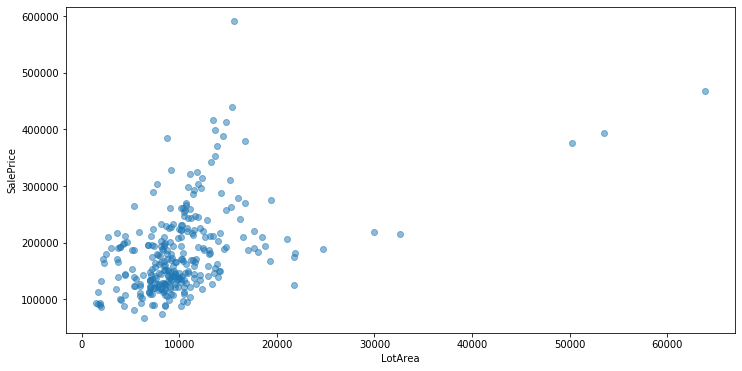

In [20]:
plt.figure(figsize=(12,6))
plt.scatter(final_X_valid.LotArea,preds_valid,alpha=0.5)
plt.xlabel('LotArea')
plt.ylabel('SalePrice')